In [1]:
%matplotlib inline
from hmmlearn import hmm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import math
import scipy.stats as stats
import statsmodels.api as sm
import gdown


In [2]:
# Define the ticker and date range
ticker = "BBCA.JK"
start_date = "2014-01-01"
end_date = "2024-11-13"

# Fetch data
data_csv = yf.download(ticker, start=start_date, end=end_date, interval="1d")

# Reset index to make the date a regular column, not the index
data_csv = data_csv.reset_index()

# Display the first few rows to confirm
print(data_csv.tail())

# Optionally, save the data to a CSV file
data_csv.to_csv("BBRI_JK.csv", index=False)

data = data_csv[data_csv.columns[1:5]]

# Calculate 95% of the total number of rows
num_rows = int(0.95 * len(data))

# Select the first 95% of rows
obs = data.iloc[:num_rows]
# Remove any rows with missing values
obs = obs.dropna()

# Print the monthly data
print(obs)
print(data)

[*********************100%***********************]  1 of 1 completed
           Date     Open     High      Low    Close     Adj Close     Volume
2683 2024-11-06  10475.0  10500.0  10375.0  10450.0  10398.138672   50324900
2684 2024-11-07  10325.0  10450.0  10175.0  10175.0  10124.503906  131579100
2685 2024-11-08  10200.0  10225.0  10050.0  10075.0  10025.000000   92166100
2686 2024-11-11   9800.0  10050.0   9800.0  10050.0  10000.124023  128707600
2687 2024-11-12  10100.0  10225.0  10000.0  10150.0  10099.627930   80378500
         Open     High     Low   Close
0      1940.0   1970.0  1930.0  1960.0
1      1940.0   1950.0  1870.0  1900.0
2      1880.0   1900.0  1860.0  1870.0
3      1870.0   1890.0  1865.0  1875.0
4      1880.0   1890.0  1850.0  1865.0
...       ...      ...     ...     ...
2548   9350.0   9500.0  9300.0  9475.0
2549   9400.0   9425.0  9350.0  9350.0
2550   9400.0   9775.0  9400.0  9725.0
2551   9825.0   9950.0  9750.0  9950.0
2552  10000.0  10000.0  9700.0  9775.0



In [3]:
#Find Optimal States
T = 120
AIC, BIC, HQC, CAIC = [], [], [], []

for n in range(2, 7):
    a, b, c, d = [], [], [], []
    first_time = True

    for i in range(0, T):
        
        if first_time:
            model = hmm.GaussianHMM(n_components=n, init_params="stmc", n_iter=5000)
            first_time = False
        else:
            old_model = model
            model = hmm.GaussianHMM(n_components=n, init_params="", n_iter=5000)
            model.startprob_ = old_model.startprob_
            model.transmat_ = old_model.transmat_
            model.means_ = old_model.means_

            # Normalize startprob_ to ensure it sums to 1
            model.startprob_ = model.startprob_ / np.sum(model.startprob_)

            # Ensure transition matrix rows sum to 1
            model.transmat_ = np.divide(model.transmat_, model.transmat_.sum(axis=1, keepdims=True))

            # If any row sums to 0, reinitialize it to uniform probabilities
            for row in range(n):
                if np.sum(model.transmat_[row]) == 0:
                    model.transmat_[row] = np.full(n, 1 / n)

        # Fit the model using the data
        model.fit(obs[i:i+T])

        log_likelihoods = model.score(obs[i:i+T])
        k = n**2 + 2*n - 1

        aic = -2 * log_likelihoods + 2 * k
        bic = -2 * log_likelihoods + k * np.log(4 * T)
        hqc = -2 * log_likelihoods + k * (np.log(np.log(4 * T)))
        caic = -2 * log_likelihoods + k * (np.log(4 * T) + 1)

        a.append(aic)
        b.append(bic)
        c.append(hqc)
        d.append(caic)

    AIC.append(a)
    BIC.append(b)
    HQC.append(c)
    CAIC.append(d)


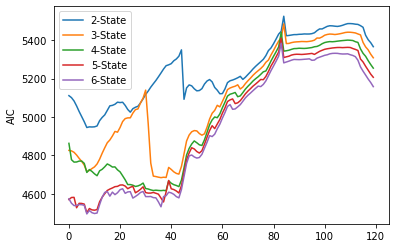

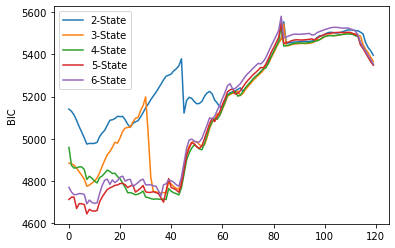

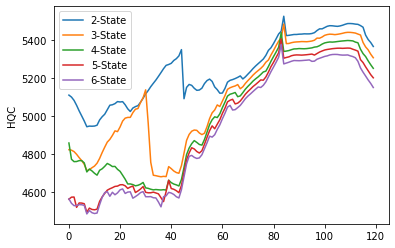

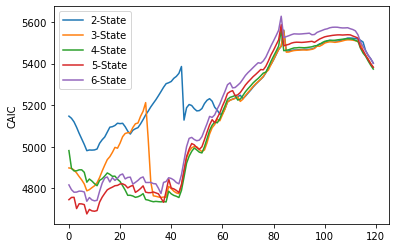

In [4]:
# Plot AIC values for different numbers of components
for i in range(0, 5):
    plt.plot(AIC[i], label=f"{i+2}-State")
plt.ylabel("AIC")

plt.legend()
plt.show()

# Plot BIC values for different numbers of components
for i in range(0, 5):
    plt.plot(BIC[i], label=f"{i+2}-State")
plt.ylabel("BIC")
plt.legend()
plt.show()

# Plot HQC values for different numbers of components
for i in range(0, 5):
    plt.plot(HQC[i], label=f"{i+2}-State")
plt.ylabel("HQC")
plt.legend()
plt.show()

# Plot CAIC values for different numbers of components
for i in range(0, 5):
    plt.plot(CAIC[i], label=f"{i+2}-State")
plt.ylabel("CAIC")
plt.legend()
plt.show()

In [5]:
# Create Historical Likelihood
first_time = True
n=6
T = 120
w = len(obs) - T
likelihood_list = []  

# Creating Likelihood from trained data
for i in range(0, w):
    
    np.random.seed(1234)
    if first_time:
        model = hmm.GaussianHMM(n_components=n, init_params="stmc", n_iter=5000)
        first_time = False
    else:
        old_model = model
        model = hmm.GaussianHMM(n_components=n, init_params="", n_iter=5000)

        # Ensure model parameters match the expected number of components
        model.startprob_ = np.zeros(n)  # Initialize with zeros
        model.transmat_ = np.zeros((n, n))  # Initialize with zeros
        model.means_ = np.zeros((n, old_model.means_.shape[1]))  # Match means dimensions

        # Copy parameters from old model
        if old_model.startprob_.shape[0] == n:
            model.startprob_ = old_model.startprob_
        if old_model.transmat_.shape == (n, n):
            model.transmat_ = old_model.transmat_
        if old_model.means_.shape[0] == n:
            model.means_ = old_model.means_

        # Normalize startprob_ to ensure it sums to 1
        model.startprob_ /= np.sum(model.startprob_)

        # Ensure transition matrix rows sum to 1
        model.transmat_ = np.divide(model.transmat_, model.transmat_.sum(axis=1, keepdims=True))

        # If any row sums to 0, reinitialize it to uniform probabilities
        for row in range(n):
            if row < model.transmat_.shape[0] and np.sum(model.transmat_[row]) == 0:
                model.transmat_[row] = np.full(n, 1 / n)

        # Check for NaNs and reinitialize if necessary
        if np.isnan(model.startprob_).any() or np.isnan(model.transmat_).any():
            print("Invalid parameters detected, reinitializing...")
            model.startprob_ = np.full(n, 1 / n)
            model.transmat_ = np.full((n, n), 1 / n)

    # Fit the model using the data
    model.fit(obs[i:i+T])
    likelihoods = model.score(obs[i:i+T])
    likelihood_list.append(likelihoods)  # Append the likelihood directly


In [6]:
# Match to the closest likelihood
num_test=int(0.05*len(data))
# Select the first 95% of rows
obs = data.iloc[:num_rows]
# Remove any rows with missing values
obs = obs.dropna()

for i in range (num_test) :
    np.random.seed(1234)
    old_model = model
    model = hmm.GaussianHMM(n_components=n, init_params="", n_iter=5000)

    # Ensure model parameters match the expected number of components
    model.startprob_ = np.zeros(n)  # Initialize with zeros
    model.transmat_ = np.zeros((n, n))  # Initialize with zeros
    model.means_ = np.zeros((n, old_model.means_.shape[1]))  # Match means dimensions

        # Copy parameters from old model
    if old_model.startprob_.shape[0] == n:
        model.startprob_ = old_model.startprob_
    if old_model.transmat_.shape == (n, n):
        model.transmat_ = old_model.transmat_
    if old_model.means_.shape[0] == n:
        model.means_ = old_model.means_

        # Normalize startprob_ to ensure it sums to 1
    model.startprob_ /= np.sum(model.startprob_)

        # Ensure transition matrix rows sum to 1
    model.transmat_ = np.divide(model.transmat_, model.transmat_.sum(axis=1, keepdims=True))

        # If any row sums to 0, reinitialize it to uniform probabilities
    for row in range(n):
        if row < model.transmat_.shape[0] and np.sum(model.transmat_[row]) == 0:
            model.transmat_[row] = np.full(n, 1 / n)

        # Check for NaNs and reinitialize if necessary
    if np.isnan(model.startprob_).any() or np.isnan(model.transmat_).any():
        print("Invalid parameters detected, reinitializing...")
        model.startprob_ = np.full(n, 1 / n)
        model.transmat_ = np.full((n, n), 1 / n)

    # Fit the model using the data
    model.fit(obs[w+i:w+i+T])
    curr_likelihood = model.score(obs[w+i:w+i+T])
    # Initialize variables to track the minimum difference and corresponding index
    min_diff = float('inf')  # Start with infinity for the minimum difference
    min_index = -1           # Initialize index for the minimum difference

    # Step 1: Loop through the likelihood_list
    for k, likelihood in enumerate(likelihood_list):
        diff = abs(curr_likelihood - likelihood)  # Calculate the absolute difference
    
        # Step 2: Check if this is the smallest difference
        if diff < min_diff:
            min_diff = diff  # Update the minimum difference
            min_index = k    # Update the index of the closest likelihood

    # Step 3: Get the corresponding likelihood value
    closest_likelihood = likelihood_list[min_index]
    row_values1 = obs.iloc[min_index + T]
    row_values2 = obs.iloc[min_index + T+1]
    
    # Calculate the next day price
    close_price = obs['Close'].iloc[-1] + (( row_values2['Close'] -  row_values1['Close']) * np.sign(curr_likelihood - closest_likelihood))
    open_price = obs['Open'].iloc[-1] + (( row_values2['Open'] - row_values1['Open']) * np.sign(curr_likelihood - closest_likelihood))
    high_price = obs['High'].iloc[-1] + (( row_values2['High'] -  row_values1['High']) * np.sign(curr_likelihood - closest_likelihood))
    low_price = obs['Low'].iloc[-1] + (( row_values2['Low']-  row_values1['Low']) * np.sign(curr_likelihood - closest_likelihood))

    new_row = {'Open': open_price, 'High': high_price, 'Low': low_price, 'Close': close_price}
    new_row_df = pd.DataFrame([new_row])  # Create a DataFrame from the dictionary
    obs = pd.concat([obs, new_row_df], ignore_index=True)
    
    # Step 4: Display the result
    print(f" iteration {i}The closest likelihood value to {curr_likelihood} is {closest_likelihood} at index {min_index}.")


 iteration 0The closest likelihood value to -3477.5683463612495 is -3477.8597496520138 at index 2066.
 iteration 1The closest likelihood value to -3475.298245663958 is -3475.0697953690683 at index 1835.
 iteration 2The closest likelihood value to -3470.8023660955387 is -3470.2749470284857 at index 2414.
 iteration 3The closest likelihood value to -3467.555413786953 is -3467.6744100789115 at index 1584.
 iteration 4The closest likelihood value to -3463.6947499228168 is -3463.624143006502 at index 2061.
 iteration 5The closest likelihood value to -3459.6521222460874 is -3459.7104284694706 at index 1833.
 iteration 6The closest likelihood value to -3455.85724584946 is -3456.048134655161 at index 1900.
 iteration 7The closest likelihood value to -3453.555858565073 is -3453.676306736892 at index 1901.
 iteration 8The closest likelihood value to -3452.198212824682 is -3451.936037924631 at index 1689.
 iteration 9The closest likelihood value to -3451.226433461958 is -3451.4045729009385 at ind

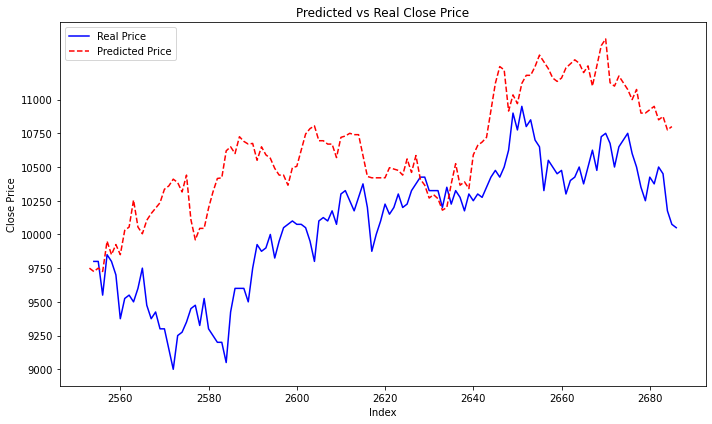

In [7]:
import matplotlib.pyplot as plt

# Assuming num_test is defined
predicted_price = obs["Close"].iloc[-(num_test):-1]
real_price = data["Close"].iloc[-(num_test):-1]

# Plot predicted vs real prices
plt.figure(figsize=(10, 6))

# Plot real prices
plt.plot(real_price.index, real_price, label='Real Price', color='blue')

# Plot predicted prices
plt.plot(predicted_price.index, predicted_price, label='Predicted Price', color='red', linestyle='--')

# Add labels, title, and legend
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.title('Predicted vs Real Close Price')
plt.legend()

# Set y-axis ticks with a step of 500
plt.yticks(range(int(real_price.min()), int(real_price.max()) + 250, 250))

# Show plot
plt.tight_layout()
plt.show()


In [8]:
mape = (abs((real_price - predicted_price) / real_price)).mean() * 100

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Percentage Error (MAPE): 5.55%


In [9]:
predicted_price

2553     9750.0
2554     9725.0
2555     9750.0
2556     9725.0
2557     9950.0
         ...   
2681    10950.0
2682    10850.0
2683    10875.0
2684    10775.0
2685    10800.0
Name: Close, Length: 133, dtype: float64

In [10]:
real_price

2554     9800.0
2555     9800.0
2556     9550.0
2557     9850.0
2558     9800.0
         ...   
2682    10500.0
2683    10450.0
2684    10175.0
2685    10075.0
2686    10050.0
Name: Close, Length: 133, dtype: float64

In [11]:
# Data Test As Newest Price instead of predicted price

num_test=int(0.05*len(data))
data = data_csv[data_csv.columns[1:5]]

# Calculate 95% of the total number of rows
num_rows = int(0.95 * len(data))

# Select the first 95% of rows
obs = data.iloc[:num_rows]
# Remove any rows with missing values
obs = obs.dropna()


for i in range (num_test) :
    old_model = model
    model = hmm.GaussianHMM(n_components=n, init_params="", n_iter=1000)

    # Ensure model parameters match the expected number of components
    model.startprob_ = np.zeros(n)  # Initialize with zeros
    model.transmat_ = np.zeros((n, n))  # Initialize with zeros
    model.means_ = np.zeros((n, old_model.means_.shape[1]))  # Match means dimensions

        # Copy parameters from old model
    if old_model.startprob_.shape[0] == n:
        model.startprob_ = old_model.startprob_
    if old_model.transmat_.shape == (n, n):
        model.transmat_ = old_model.transmat_
    if old_model.means_.shape[0] == n:
        model.means_ = old_model.means_

        # Normalize startprob_ to ensure it sums to 1
    model.startprob_ /= np.sum(model.startprob_)

        # Ensure transition matrix rows sum to 1
    model.transmat_ = np.divide(model.transmat_, model.transmat_.sum(axis=1, keepdims=True))

        # If any row sums to 0, reinitialize it to uniform probabilities
    for row in range(n):
        if row < model.transmat_.shape[0] and np.sum(model.transmat_[row]) == 0:
            model.transmat_[row] = np.full(n, 1 / n)

        # Check for NaNs and reinitialize if necessary
    if np.isnan(model.startprob_).any() or np.isnan(model.transmat_).any():
        print("Invalid parameters detected, reinitializing...")
        model.startprob_ = np.full(n, 1 / n)
        model.transmat_ = np.full((n, n), 1 / n)

    # Fit the model using the data
    model.fit(obs[w+i:w+i+T])
    curr_likelihood = model.score(obs[w+i:w+i+T])
    # Initialize variables to track the minimum difference and corresponding index
    min_diff = float('inf')  # Start with infinity for the minimum difference
    min_index = -1           # Initialize index for the minimum difference

    # Step 1: Loop through the likelihood_list
    for k, likelihood in enumerate(likelihood_list):
        diff = abs(curr_likelihood - likelihood)  # Calculate the absolute difference
    
        # Step 2: Check if this is the smallest difference
        if diff < min_diff:
            min_diff = diff  # Update the minimum difference
            min_index = k    # Update the index of the closest likelihood

    # Step 3: Get the corresponding likelihood value
    closest_likelihood = likelihood_list[min_index]
    row_values1 = obs.iloc[min_index + T]
    row_values2 = obs.iloc[min_index + T+1]
    
    # Calculate the next day price
    close_price = data['Close'].iloc[len(obs)] + (( row_values2['Close'] -  row_values1['Close']) * np.sign(curr_likelihood - closest_likelihood))
    open_price = data['Open'].iloc[len(obs)] + (( row_values2['Open'] - row_values1['Open']) * np.sign(curr_likelihood - closest_likelihood))
    high_price = data['High'].iloc[len(obs)] + (( row_values2['High'] -  row_values1['High']) * np.sign(curr_likelihood - closest_likelihood))
    low_price = data['Low'].iloc[len(obs)] + (( row_values2['Low']-  row_values1['Low']) * np.sign(curr_likelihood - closest_likelihood))

    new_row = {'Open': open_price, 'High': high_price, 'Low': low_price, 'Close': close_price}
    new_row_df = pd.DataFrame([new_row])  # Create a DataFrame from the dictionary
    obs = pd.concat([obs, new_row_df], ignore_index=True)
    
    # Step 4: Display the result
    print(f" iteration {i}The closest likelihood value to {curr_likelihood} is {closest_likelihood} at index {min_index}.")


 iteration 0The closest likelihood value to -3477.5683463612495 is -3477.8597496520138 at index 2066.
 iteration 1The closest likelihood value to -3474.180014312552 is -3474.1523370571595 at index 1894.
 iteration 2The closest likelihood value to -3469.1412265131576 is -3469.020500232505 at index 1640.
 iteration 3The closest likelihood value to -3465.697991230371 is -3465.7116973797506 at index 2413.
 iteration 4The closest likelihood value to -3461.4395670672297 is -3460.528406515451 at index 1897.
 iteration 5The closest likelihood value to -3455.047586883479 is -3456.048134655161 at index 1900.
 iteration 6The closest likelihood value to -3451.0127092334205 is -3450.853895623776 at index 2059.
 iteration 7The closest likelihood value to -3447.757228451238 is -3447.6652612219764 at index 1904.
 iteration 8The closest likelihood value to -3445.437275503481 is -3444.8772473495337 at index 2058.
 iteration 9The closest likelihood value to -3442.9195816158594 is -3442.9198677079335 at i

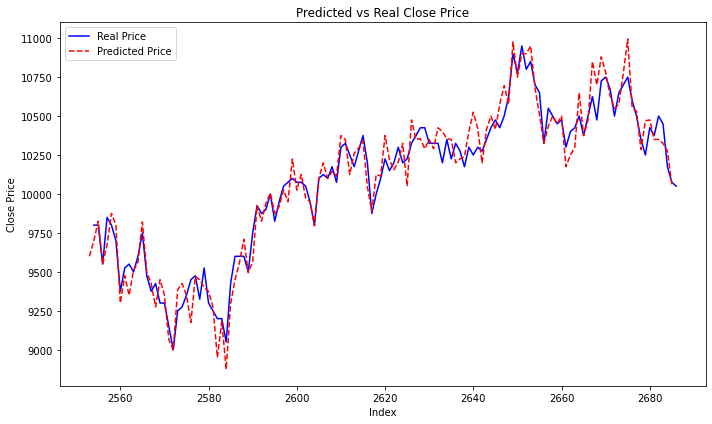

In [12]:
import matplotlib.pyplot as plt

# Assuming num_test is defined
predicted_price = obs["Close"].iloc[-(num_test):-1]
real_price = data["Close"].iloc[-(num_test):-1]

# Plot predicted vs real prices
plt.figure(figsize=(10, 6))

# Plot real prices
plt.plot(real_price.index, real_price, label='Real Price', color='blue')

# Plot predicted prices
plt.plot(predicted_price.index, predicted_price, label='Predicted Price', color='red', linestyle='--')

# Add labels, title, and legend
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.title('Predicted vs Real Close Price')
plt.legend()

# Set y-axis ticks with a step of 500
plt.yticks(range(int(real_price.min()), int(real_price.max()) + 250, 250))

# Show plot
plt.tight_layout()
plt.show()

In [13]:
mape = (abs((real_price - predicted_price) / real_price)).mean() * 100

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Percentage Error (MAPE): 0.83%


In [14]:
#Out of Sample

obs=data
first_time = True
n=6
T = 120
w = len(obs) - T
likelihood_list = []  

# Creating Likelihood from trained data
for i in range(0, w):
    
    np.random.seed(1234)
    if first_time:
        model = hmm.GaussianHMM(n_components=n, init_params="stmc", n_iter=5000)
        first_time = False
    else:
        old_model = model
        model = hmm.GaussianHMM(n_components=n, init_params="", n_iter=5000)

        # Ensure model parameters match the expected number of components
        model.startprob_ = np.zeros(n)  # Initialize with zeros
        model.transmat_ = np.zeros((n, n))  # Initialize with zeros
        model.means_ = np.zeros((n, old_model.means_.shape[1]))  # Match means dimensions

        # Copy parameters from old model
        if old_model.startprob_.shape[0] == n:
            model.startprob_ = old_model.startprob_
        if old_model.transmat_.shape == (n, n):
            model.transmat_ = old_model.transmat_
        if old_model.means_.shape[0] == n:
            model.means_ = old_model.means_

        # Normalize startprob_ to ensure it sums to 1
        model.startprob_ /= np.sum(model.startprob_)

        # Ensure transition matrix rows sum to 1
        model.transmat_ = np.divide(model.transmat_, model.transmat_.sum(axis=1, keepdims=True))

        # If any row sums to 0, reinitialize it to uniform probabilities
        for row in range(n):
            if row < model.transmat_.shape[0] and np.sum(model.transmat_[row]) == 0:
                model.transmat_[row] = np.full(n, 1 / n)

        # Check for NaNs and reinitialize if necessary
        if np.isnan(model.startprob_).any() or np.isnan(model.transmat_).any():
            print("Invalid parameters detected, reinitializing...")
            model.startprob_ = np.full(n, 1 / n)
            model.transmat_ = np.full((n, n), 1 / n)

    # Fit the model using the data
    model.fit(obs[i:i+T])
    likelihoods = model.score(obs[i:i+T])
    likelihood_list.append(likelihoods)  # Append the likelihood directly


In [15]:

for i in range (num_test) :
    np.random.seed(1234)
    old_model = model
    model = hmm.GaussianHMM(n_components=n, init_params="", n_iter=5000)

    # Ensure model parameters match the expected number of components
    model.startprob_ = np.zeros(n)  # Initialize with zeros
    model.transmat_ = np.zeros((n, n))  # Initialize with zeros
    model.means_ = np.zeros((n, old_model.means_.shape[1]))  # Match means dimensions

        # Copy parameters from old model
    if old_model.startprob_.shape[0] == n:
        model.startprob_ = old_model.startprob_
    if old_model.transmat_.shape == (n, n):
        model.transmat_ = old_model.transmat_
    if old_model.means_.shape[0] == n:
        model.means_ = old_model.means_

        # Normalize startprob_ to ensure it sums to 1
    model.startprob_ /= np.sum(model.startprob_)

        # Ensure transition matrix rows sum to 1
    model.transmat_ = np.divide(model.transmat_, model.transmat_.sum(axis=1, keepdims=True))

        # If any row sums to 0, reinitialize it to uniform probabilities
    for row in range(n):
        if row < model.transmat_.shape[0] and np.sum(model.transmat_[row]) == 0:
            model.transmat_[row] = np.full(n, 1 / n)

        # Check for NaNs and reinitialize if necessary
    if np.isnan(model.startprob_).any() or np.isnan(model.transmat_).any():
        print("Invalid parameters detected, reinitializing...")
        model.startprob_ = np.full(n, 1 / n)
        model.transmat_ = np.full((n, n), 1 / n)

    # Fit the model using the data
    model.fit(obs[w+i:w+i+T])
    curr_likelihood = model.score(obs[w+i:w+i+T])
    # Initialize variables to track the minimum difference and corresponding index
    min_diff = float('inf')  # Start with infinity for the minimum difference
    min_index = -1           # Initialize index for the minimum difference

    # Step 1: Loop through the likelihood_list
    for k, likelihood in enumerate(likelihood_list):
        diff = abs(curr_likelihood - likelihood)  # Calculate the absolute difference
    
        # Step 2: Check if this is the smallest difference
        if diff < min_diff:
            min_diff = diff  # Update the minimum difference
            min_index = k    # Update the index of the closest likelihood

    # Step 3: Get the corresponding likelihood value
    closest_likelihood = likelihood_list[min_index]
    row_values1 = obs.iloc[min_index + T]
    row_values2 = obs.iloc[min_index + T+1]
    
    # Calculate the next day price
    close_price = obs['Close'].iloc[-1] + (( row_values2['Close'] -  row_values1['Close']) * np.sign(curr_likelihood - closest_likelihood))
    open_price = obs['Open'].iloc[-1] + (( row_values2['Open'] - row_values1['Open']) * np.sign(curr_likelihood - closest_likelihood))
    high_price = obs['High'].iloc[-1] + (( row_values2['High'] -  row_values1['High']) * np.sign(curr_likelihood - closest_likelihood))
    low_price = obs['Low'].iloc[-1] + (( row_values2['Low']-  row_values1['Low']) * np.sign(curr_likelihood - closest_likelihood))

    new_row = {'Open': open_price, 'High': high_price, 'Low': low_price, 'Close': close_price}
    new_row_df = pd.DataFrame([new_row])  # Create a DataFrame from the dictionary
    obs = pd.concat([obs, new_row_df], ignore_index=True)
    
    # Step 4: Display the result
    print(f" iteration {i}The closest likelihood value to {curr_likelihood} is {closest_likelihood} at index {min_index}.")


 iteration 0The closest likelihood value to -3438.95689536775 is -3439.0198051987145 at index 2057.
 iteration 1The closest likelihood value to -3423.151180522788 is -3423.5226650237278 at index 1635.
 iteration 2The closest likelihood value to -3410.2575308917894 is -3410.6501646861325 at index 2051.
 iteration 3The closest likelihood value to -3400.6210737011675 is -3400.8179891393147 at index 2530.
 iteration 4The closest likelihood value to -3392.8627784860414 is -3393.0547959563014 at index 1697.
 iteration 5The closest likelihood value to -3385.5895365480346 is -3385.5353841200467 at index 1918.
 iteration 6The closest likelihood value to -3378.309899044888 is -3378.992662152474 at index 2401.
 iteration 7The closest likelihood value to -3369.1763519862375 is -3369.277500999369 at index 2521.
 iteration 8The closest likelihood value to -3361.378133184045 is -3360.7227118536803 at index 1825.
 iteration 9The closest likelihood value to -3351.217596232104 is -3351.06527023111 at in

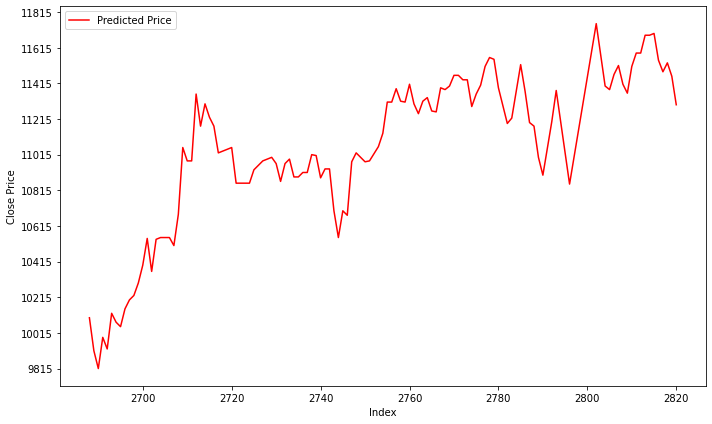

In [16]:
import matplotlib.pyplot as plt

# Assuming num_test is defined
predicted_price = obs["Close"].iloc[-(num_test):-1]


# Plot predicted vs real prices
plt.figure(figsize=(10, 6))

# Plot predicted prices
plt.plot(predicted_price.index, predicted_price, label='Predicted Price', color='red', linestyle='-')

# Add labels, title, and legend
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()

# Set y-axis ticks with a step of 500
plt.yticks(range(int(predicted_price.min()), int(predicted_price.max()) + 200, 200))
plt.savefig(f"{ticker}_Prediction_Out.png")
# Show plot
plt.tight_layout()
plt.show()
